In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from keras import metrics

In [3]:
def conv_block(input, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same")(input)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = layers.concatenate([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bridge
    b1 = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs)
    return model

input_shape = (112, 112, 3)  # Adjust size and channels according to your dataset
model = build_unet(input_shape)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=[metrics.Precision(),
                            metrics.Recall(),
                            metrics.FalsePositives(),
                            metrics.FalseNegatives(),
                            metrics.BinaryIoU()])

In [4]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import cv2
import PIL
from PIL import Image
# Paths to your data.
images_path = './archive/crack_segmentation_dataset/train/images/'
masks_path = './archive/crack_segmentation_dataset/train/masks/'
img_size = (112, 112)

# Load and preprocess data
def load_data(images_path, masks_path, img_size):
    images = []  # List to store the images
    masks = []   # List to store the masks
    path = ''
    count = 0
    for filename in os.listdir(images_path):
        if count > 500:
            break
        img_path = images_path + filename
        mask_path = masks_path + filename  # Assuming mask has same filename
        # print(img_path)
        # Load and preprocess the image
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # print(img.size())
    #   if not img or not mask:
    #         continue
        img = cv2.resize(img, img_size) / 255.0

        # Load and preprocess the mask using OpenCV
        
        mask = cv2.resize(mask, img_size) / 255.0

        images.append(img)
        masks.append(mask)
        count += 1
    
    return np.array(images), np.array(masks)


In [5]:
# Load your data
images, masks = load_data(images_path, masks_path, (112, 112))


In [6]:
images

array([[[[0.4745098 , 0.48627451, 0.47843137],
         [0.51764706, 0.52941176, 0.52156863],
         [0.50588235, 0.51764706, 0.50980392],
         ...,
         [0.5254902 , 0.50588235, 0.49411765],
         [0.51764706, 0.49803922, 0.48627451],
         [0.50196078, 0.48235294, 0.47058824]],

        [[0.52156863, 0.53333333, 0.5254902 ],
         [0.49803922, 0.50980392, 0.50196078],
         [0.49411765, 0.50588235, 0.49803922],
         ...,
         [0.5254902 , 0.50588235, 0.49411765],
         [0.49411765, 0.4745098 , 0.4627451 ],
         [0.50588235, 0.48627451, 0.4745098 ]],

        [[0.51764706, 0.52941176, 0.52156863],
         [0.48235294, 0.49411765, 0.48627451],
         [0.49019608, 0.50196078, 0.49411765],
         ...,
         [0.52941176, 0.50980392, 0.49803922],
         [0.50980392, 0.49019608, 0.47843137],
         [0.5372549 , 0.51764706, 0.50588235]],

        ...,

        [[0.43137255, 0.41568627, 0.41176471],
         [0.37254902, 0.35686275, 0.35294118]

In [7]:
images.shape

(501, 112, 112, 3)

In [8]:
images1, masks1 = images[:500], masks[:500]

In [9]:
masks1 = np.expand_dims(masks1, axis=-1)

In [10]:
masks1.shape

(500, 112, 112, 1)

In [11]:

X_train, X_val, y_train, y_val = train_test_split(images1, masks1, test_size=0.2)
X_train = X_train.reshape((-1, 112, 112, 3))
X_val = X_val.reshape((-1, 112, 112, 3))
y_train = y_train.reshape((-1, 112, 112, 1))
y_val = y_val.reshape((-1, 112, 112, 1))
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


X_train shape: (400, 112, 112, 3)
y_train shape: (400, 112, 112, 1)
X_val shape: (100, 112, 112, 3)
y_val shape: (100, 112, 112, 1)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data generators with desired augmentation parameters
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()  # No augmentation for validation data

# Generate batches of augmented data from arrays (X_train and y_train)
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Train the model using the fit_generator function
history = model.fit(
    train_generator, 
    steps_per_epoch=len(X_train) // 32,  # Number of batches per epoch
    epochs=10, 
    validation_data=val_generator,
    validation_steps=len(X_val) // 32  # Number of batches for validation
)


In [ ]:

# Load and preprocess the image
image_path = 'CFD_001.jpg'
image = cv2.imread(image_path)
image = cv2.resize(image, (112, 112))  # Resize to match your model's input shape
# image = image / 255.0  # Normalize the pixel values
cv2.imwrite( "asg.jpg", image)
# Convert the image to a NumPy array with the expected shape
# input_image = np.expand_dims(image, axis=0)  # Add a batch dimension
prediction = model.predict(input_image)
prediction

NameError: name 'input_image' is not defined

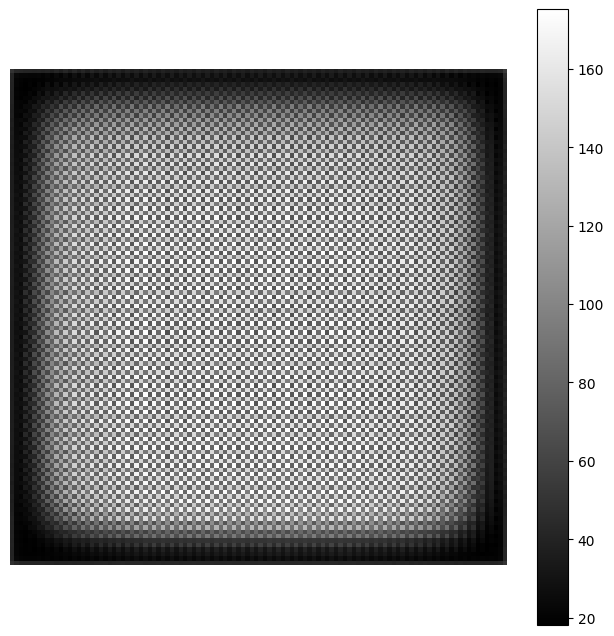

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

prediction *= 255

prediction_2d = prediction.squeeze()

plt.figure(figsize=(8, 8))
plt.imshow(prediction_2d, cmap='gray')
plt.colorbar()
plt.axis('off')
plt.show()